<a href="https://colab.research.google.com/github/iliakabanov/Adherence-to-the-Taylor-Rule-and-Monetary-Policy-Expectations/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip cache purge
# !pip uninstall -y numpy scipy rectools
# !pip install "numpy<1.29.0" "scipy<1.11.0" rectools
# !pip install lightning_fabric
# !pip install rectools
# !pip install rectools[torch]
# !pip install implicit

In [ ]:
# Get access to Google disk
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col
from pyspark.sql.functions import to_timestamp
import pyspark

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/diploma/scripts/"
import process_data

/content/drive/MyDrive/Colab Notebooks/diploma/scripts


In [ ]:
# Создаём SparkSession
spark = SparkSession.builder \
    .appName("PetCo") \
    .getOrCreate()

In [ ]:
HEAD_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/diploma/'

# Приведем датасет с логами юзеров к формату для SASRec

In [ ]:
# Read dataset with beh logs
data_logs = spark.read.parquet(HEAD_DIRECTORY+'data/needed_beh_logs')
# data_logs.show()

In [ ]:
#  Отфильтруем датасет по нужному действию
# data_actions_cleaned = process_data.clean_data_actions(data_logs, 'conversion')
# Теперь приведем датасет к формату SASRec
# data_actions_processed = process_data.actions_to_sasrec_format(data_actions_cleaned)
# print(f"Размер датасета: ({data_actions_processed.count()}, {len(data_actions_processed.columns)})")
# data_actions_processed.show(5)

In [ ]:
# Сохраним датасет формата SASRec
# sasrec_data_folder_path = HEAD_DIRECTORY+'data/sasrec_format/'
# output_name = 'actions'
# process_data.save_dataset_parquet(data_actions_processed, sasrec_data_folder_path, output_name)
# data_actions_processed = spark.read.parquet(sasrec_data_folder_path+output_name).orderBy(['user_id', 'datetime'])

Папка /content/drive/MyDrive/Colab Notebooks/diploma/data/sasrec_format/ уже существует.
Датасет сохранён по пути /content/drive/MyDrive/Colab Notebooks/diploma/data/sasrec_format/actions.


# Приведем датасет с признаками товаров к формату SASRec

In [ ]:
# Read dataset with items
data_items = spark.read.parquet(HEAD_DIRECTORY+'data/data_set_items')
# data_items.show()
# Print metadata and facets columns
# process_data.print_metadata(data_items)

In [ ]:
# Профильтруем датасет, развернув колонку метаданных и оставив только нужные метаданные и facets
metadata = ['url', 'image_url', 'itemname', 'group_ids']
facets = ['How to get it', 'Primary Brand', 'Pet Type', 'Primary Pet Type']
data_items_cleaned = process_data.clean_data_items(data_items, metadata = metadata, facets = facets)

# Приведем датасет к формату SASRec
features = ['group_ids_intersect', 'How_to_get_it', 'Primary_Brand', 'Primary_Pet_Type']
features_final_names = ['Category', 'Delivery', 'Brand', 'Pet']
data_items_processed = process_data.items_to_sasrec_format(data_items_cleaned, features, features_final_names)
# print(f"Размер датасета: ({data_items_processed.count()}, {len(data_items_processed.columns)})")
# data_items_processed.show(5)

In [ ]:
# Сохраним датасет формата SASRec
sasrec_data_folder_path = HEAD_DIRECTORY+'data/sasrec_format/'
output_name = 'items'
# process_data.save_dataset_parquet(data_items_processed, sasrec_data_folder_path, output_name)
data_items_processed = spark.read.parquet(sasrec_data_folder_path+output_name).orderBy('id', 'feature', 'value')

# Проведем прямые и косвенные тесты на корректность собранных датасетов

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/diploma/tests/tests_petco"
!pytest

/content/drive/MyDrive/Colab Notebooks/diploma/tests/tests_petco
======================================= test session starts ========================================
platform linux -- Python 3.11.11, pytest-8.3.5, pluggy-1.5.0
rootdir: /content/drive/MyDrive/Colab Notebooks/diploma/tests/tests_petco
plugins: anyio-4.9.0, typeguard-4.4.2, langsmith-0.3.15
collected 11 items                                                                                 

test_petco_direct.py ..                                                                      [ 18%]
test_petco_indirect.py .........                                                             [100%]

================================== 11 passed in 196.03s (0:03:16) ==================================


# Модель

In [ ]:
# !pip freeze > requirements.txt
# !pip install -r requirements.txt

In [ ]:
import os
import itertools
import typing as tp
import warnings
from collections import Counter
from pathlib import Path

import pandas as pd
import numpy as np
import torch
from lightning_fabric import seed_everything
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback

from rectools import Columns, ExternalIds
from rectools.dataset import Dataset
from rectools.metrics import NDCG, Recall, Serendipity, calc_metrics
from rectools.model_selection.last_n_split import LastNSplitter
from rectools.models import BERT4RecModel, SASRecModel, load_model
from rectools.models.nn.item_net import IdEmbeddingsItemNet
from rectools.models.nn.transformers.base import TransformerModelBase

In [ ]:
import numpy as np
import os
import pandas as pd
import torch
import typing as tp
import warnings
import threadpoolctl
import re
import plotly.express as px

from lightning_fabric import seed_everything
from pathlib import Path

from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import (
    MAP,
    CoveredUsers,
    AvgRecPopularity,
    Intersection,
    HitRate,
    Serendipity,
    CatalogCoverage
)
from rectools.metrics.novelty import MeanInvUserFreq
from rectools.metrics.diversity import IntraListDiversity
from rectools.metrics.distances import PairwiseHammingDistanceCalculator
from rectools.models import PopularModel, EASEModel, SASRecModel, BERT4RecModel
from rectools.model_selection import TimeRangeSplitter, cross_validate
from rectools.models.nn.item_net import CatFeaturesItemNet, IdEmbeddingsItemNet
from rectools.visuals import MetricsApp

warnings.simplefilter("ignore")

# Enable deterministic behaviour with CUDA >= 10.2
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Random seed
RANDOM_STATE=60
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

INFO:lightning_fabric.utilities.seed:Seed set to 60


60

In [ ]:
# actions, items = process_data.processed_datasets_to_pandas(data_actions_processed, data_items_processed)
# actions.to_pickle(HEAD_DIRECTORY+'data/sasrec_format/actions.pkl')
# items.to_pickle(HEAD_DIRECTORY+'data/sasrec_format/items.pkl')
actions = pd.read_pickle(HEAD_DIRECTORY+'data/sasrec_format/actions.pkl')
items = pd.read_pickle(HEAD_DIRECTORY+'data/sasrec_format/items.pkl')
catalog = pd.read_pickle(HEAD_DIRECTORY+'data/sasrec_format/catalog.pkl')

In [ ]:
# Construct dataset
features_final_names = ['Category', 'Delivery', 'Brand', 'Pet']
dataset = Dataset.construct(
    interactions_df=actions,
    item_features_df=items,
    cat_item_features=features_final_names,
)

In [ ]:
model = SASRecModel(
    deterministic=True,
    loss="softmax",
    item_net_block_types=(IdEmbeddingsItemNet, CatFeaturesItemNet),  # Use item ids and cat features
    get_val_mask_func=get_val_mask_func
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Implement `get_val_mask_func`

N_VAL_USERS = 2048
unique_users = actions['user_id'].unique()
VAL_USERS = unique_users

def leave_one_out_mask_for_users(interactions: pd.DataFrame, val_users: ExternalIds) -> np.ndarray:
    rank = (
        interactions
        .sort_values(Columns.Datetime, ascending=False, kind="stable")
        .groupby(Columns.User, sort=False)
        .cumcount()
    )
    val_mask = (
        (interactions[Columns.User].isin(val_users))
        & (rank == 0)
    )
    return val_mask.values

# We do not use `partial` for correct serialization of the model
def get_val_mask_func(interactions: pd.DataFrame):
    return leave_one_out_mask_for_users(interactions, val_users = VAL_USERS)

In [ ]:
get_val_mask_func(actions)

array([False, False, False, ...,  True, False,  True])

In [ ]:
# Checkpoint last epoch
last_epoch_ckpt = ModelCheckpoint(filename="last_epoch")

trainer = Trainer(
    accelerator="gpu",
    # devices=2,
    min_epochs=2,
    max_epochs=20,
    deterministic=True,
    limit_train_batches=10,  # use only 2 batches for each epoch for a test run
    logger = CSVLogger(save_dir=HEAD_DIRECTORY+'models'),
    callbacks=[last_epoch_ckpt],  # pass our callbacks for checkpoints
    enable_progress_bar=True,
    enable_model_summary=True
)

# Replace trainer with our custom one
model._trainer = trainer

# Fit model. Everything will happen under the hood
model.fit(dataset)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 6.1 M  | train
-----------------------------------------------------------------
6.1 M     Trainable params
0         Non-trainable params
6.1 M     Total params
24.317    Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
# ckpt_path = os.path.join(model.fit_trainer.log_dir, "checkpoints", "last_epoch.ckpt")
ckpt_path = HEAD_DIRECTORY+'models/lightning_logs/version_13/checkpoints/epoch=479-NDCG@10=0.04.ckpt'
model = SASRecModel.load_from_checkpoint(ckpt_path)
# loaded.recommend(users=VAL_USERS[:1], dataset=dataset, filter_viewed=True, k=5)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Implement custom Callback for RecTools metrics computation within validation epochs during training.

class ValidationMetrics(Callback):

    def __init__(self, top_k: int, val_metrics: tp.Dict, verbose: int = 0) -> None:
        self.top_k = top_k
        self.val_metrics = val_metrics
        self.verbose = verbose

        self.epoch_n_users: int = 0
        self.batch_metrics: tp.List[tp.Dict[str, float]] = []

    def on_validation_batch_end(
        self,
        trainer: Trainer,
        pl_module: LightningModule,
        outputs: tp.Dict[str, torch.Tensor],
        batch: tp.Dict[str, torch.Tensor],
        batch_idx: int,
        dataloader_idx: int = 0
    ) -> None:
        logits = outputs["logits"]
        if logits is None:
            logits = pl_module.torch_model.encode_sessions(batch["x"], pl_module.item_embs)[:, -1, :]
        _, sorted_batch_recos = logits.topk(k=self.top_k)

        batch_recos = sorted_batch_recos.tolist()
        targets = batch["y"].tolist()

        batch_val_users = list(
            itertools.chain.from_iterable(
                itertools.repeat(idx, len(recos)) for idx, recos in enumerate(batch_recos)
            )
        )

        batch_target_users = list(
            itertools.chain.from_iterable(
                itertools.repeat(idx, len(targets)) for idx, targets in enumerate(targets)
            )
        )

        batch_recos_df = pd.DataFrame(
            {
                Columns.User: batch_val_users,
                Columns.Item: list(itertools.chain.from_iterable(batch_recos)),
            }
        )
        batch_recos_df[Columns.Rank] = batch_recos_df.groupby(Columns.User, sort=False).cumcount() + 1

        interactions = pd.DataFrame(
            {
                Columns.User: batch_target_users,
                Columns.Item: list(itertools.chain.from_iterable(targets)),
            }
        )

        prev_interactions = pl_module.data_preparator.train_dataset.interactions.df
        catalog = prev_interactions[Columns.Item].unique()

        batch_metrics = calc_metrics(
            self.val_metrics,
            batch_recos_df,
            interactions,
            prev_interactions,
            catalog
        )

        batch_n_users = batch["x"].shape[0]
        self.batch_metrics.append({metric: value * batch_n_users for metric, value in batch_metrics.items()})
        self.epoch_n_users += batch_n_users

    def on_validation_epoch_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        epoch_metrics = dict(sum(map(Counter, self.batch_metrics), Counter()))
        epoch_metrics = {metric: value / self.epoch_n_users for metric, value in epoch_metrics.items()}

        self.log_dict(epoch_metrics, on_step=False, on_epoch=True, prog_bar=self.verbose > 0)

        self.batch_metrics.clear()
        self.epoch_n_users = 0

In [ ]:
# Initialize callbacks for metrics calculation and checkpoint based on NDCG value

metrics = {
    "NDCG@10": NDCG(k=10),
    "Recall@10": Recall(k=10),
    "Serendipity@10": Serendipity(k=10),
}
top_k = max([metric.k for metric in metrics.values()])

# Callback for calculating RecSys metrics
val_metrics_callback = ValidationMetrics(top_k=top_k, val_metrics=metrics, verbose=0)

# Callback for checkpoint based on maximization of NDCG@10
best_ndcg_ckpt = ModelCheckpoint(
    monitor="NDCG@10",
    mode="max",
    filename="{epoch}-{NDCG@10:.2f}",
)

In [ ]:
trainer = Trainer(
    accelerator="gpu",
    # devices=1,
    min_epochs=2,
    max_epochs=500,
    deterministic=True,
    limit_train_batches=2,  # use only 2 batches for each epoch for a test run
    callbacks=[val_metrics_callback, best_ndcg_ckpt],  # pass our callbacks
    check_val_every_n_epoch=10,
    logger = CSVLogger(save_dir=HEAD_DIRECTORY+'models'),
    enable_progress_bar=True,
    enable_model_summary=True,
)

# Replace trainer with our custom one
model._trainer = trainer

# Fit model. Everything will happen under the hood
model.fit(dataset)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type                     | Params | Mode 
-----------------------------------------------------------------
0 | torch_model | TransformerTorchBackbone | 6.1 M  | train
-----------------------------------------------------------------
6.1 M     Trainable params
0         Non-trainable params
6.1 M     Total params
24.317    Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


In [ ]:
def get_logs(model: TransformerModelBase) -> tp.Tuple[pd.DataFrame, ...]:
    log_path = HEAD_DIRECTORY+'models/lightning_logs/version_13/metrics.csv'
    epoch_metrics_df = pd.read_csv(log_path)

    loss_df = epoch_metrics_df[["epoch", "train_loss"]].dropna()
    val_loss_df = epoch_metrics_df[["epoch", "val_loss"]].dropna()
    loss_df = pd.merge(loss_df, val_loss_df, how="inner", on="epoch")
    loss_df.reset_index(drop=True, inplace=True)

    metrics_df = epoch_metrics_df.drop(columns=["train_loss", "val_loss"]).dropna()
    metrics_df.reset_index(drop=True, inplace=True)

    return loss_df, metrics_df

loss_df, metrics_df = get_logs(model)

In [ ]:
metrics_df

,NDCG@10,Recall@10,Serendipity@10,epoch,step
0,0.027557,0.205061,0.000245,9,19
1,0.029524,0.223053,0.000263,19,39
2,0.031202,0.235011,0.000277,29,59
3,0.032763,0.244248,0.000294,39,79
4,0.032644,0.244301,0.000290,49,99
5,0.033792,0.251295,0.000302,59,119
6,0.034362,0.257221,0.000310,69,139
7,0.035218,0.260958,0.000316,79,159
8,0.035235,0.262399,0.000318,89,179
9,0.035583,0.266083,0.000325,99,199


In [ ]:
loss_df

,epoch,train_loss,val_loss
0,9,7.148216,7.404307
1,19,6.608335,7.086933
2,29,6.542275,6.907862
3,39,6.591539,6.820268
4,49,6.402417,6.748796
5,59,6.262030,6.708524
6,69,6.194706,6.641897
7,79,6.070729,6.598097
8,89,6.128314,6.555603
9,99,6.170877,6.545855


<Axes: title={'center': 'Losses'}, xlabel='epoch'>

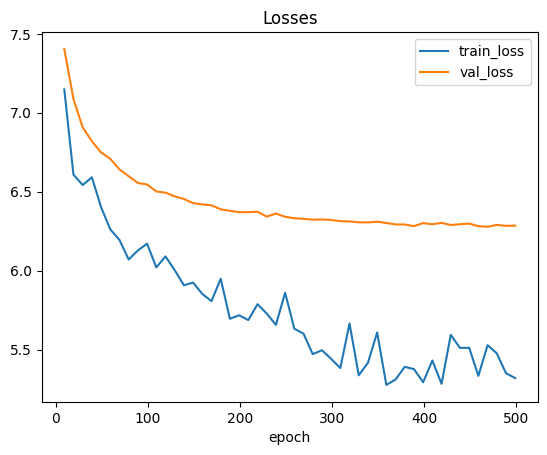

In [ ]:
loss_df.plot(kind="line", x="epoch", title="Losses")

<Axes: title={'center': 'NDCG'}, xlabel='epoch'>

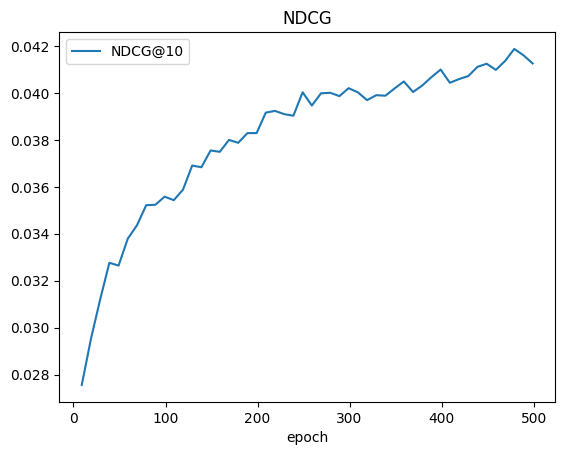

In [ ]:
metrics_df[["epoch", "NDCG@10"]].plot(kind="line", x="epoch", title="NDCG")

In [ ]:
pivot_results = (
    pd.DataFrame(cv_results["metrics"])
    .drop(columns="i_split")
    .groupby(["model"], sort=False)
    .agg(["mean"])
)
pivot_results.columns = pivot_results.columns.droplevel(1)
pivot_results.to_csv("rectools_transformers_cv.csv", index=True)
pivot_results

In [ ]:
# В валлидационный датасет откладываем последнее действие для каждого юзера
val_df = actions.loc[actions.groupby("user_id")["datetime"].idxmax()]

# Обучающий датасет – все, кроме последней итерации у каждого пользователя
train_df = actions.drop(val_df.index)

# Construct dataset
features_final_names = ['Category', 'Delivery', 'Brand', 'Pet']
train_dataset = Dataset.construct(
    interactions_df=train_df,
    item_features_df=items,
    cat_item_features=features_final_names,
)

val_dataset = Dataset.construct(
    interactions_df=val_df,
    item_features_df=items,
    cat_item_features=features_final_names,
)

In [ ]:
pop_model = PopularModel("n_interactions")
pop_model.fit(train_dataset)

In [ ]:
def eval_models(models, metrics, train_dataset, val_dataset, catalog):
  results = pd.DataFrame(columns=['model']+list(metrics.keys()))
  for model_name, model in models.items():
    print(model_name)
    if model_name == 'SASRec':
      recos = sasrec_recos
    else:
      recos = model.recommend(TEST_USERS, train_dataset, k=10, filter_viewed=False)
    model_results = {'model': [model_name]}
    for metric_name, metric in metrics.items():
      print(metric_name)
      if 'Serendipity' in metric_name:
        model_results[metric_name] = [metric.calc(recos, val_df, train_df, catalog['item_id'].unique())]
      elif "AvgRecPopularity" in metric_name:
        model_results[metric_name] = [metric.calc(recos, train_df)]
      elif "CatalogCoverage" in metric_name:
        model_results[metric_name] = [metric.calc(recos, catalog['item_id'].unique())/len(catalog)]
      elif 'Novelty' in metric_name:
        model_results[metric_name] = [metric.calc(recos, val_df)]
      elif 'Diversity' in metric_name:
        model_results[metric_name] = [metric.calc(recos)]
      else:
        model_results[metric_name] = [metric.calc(reco=recos, interactions=val_df)]

    results = pd.concat([results, pd.DataFrame(model_results)], ignore_index=True)

  return results

In [ ]:
import pickle
item_embeddings_path = HEAD_DIRECTORY+'embeddings/item_embeddings_val_1.pkl'
with open(item_embeddings_path, "rb") as f:
          item_embeddings = pd.DataFrame.from_dict(pickle.load(f), orient='index')

In [ ]:
metrics = {
    "NDCG@5": NDCG(k=5),
    "Recall@5": Recall(k=5),
    "HitRate@5" :HitRate(k=5),
    "CatalogCoverage@5": CatalogCoverage(k=5),
    "Novelty@5": MeanInvUserFreq(k=5),
    "Diversity@5": IntraListDiversity(k=5, distance_calculator=PairwiseHammingDistanceCalculator(item_features_df=item_embeddings)),
    "Serendipity@5": Serendipity(k=5),
    "AvgRecPopularity@5": AvgRecPopularity(k=5),  # average popularity of recommended items
}

models = {
    "Popular": pop_model,
    "PopCat": pop_cat_model,
    "PopUser": pop_user_model,
    "BPR": bpr_model,
    "ALS": als_model,
    "SASRec" : None
}

In [ ]:
user_counts = train_df['user_id'].value_counts()
TEST_USERS = user_counts[user_counts > 1].index

results = eval_models(models, metrics, train_dataset, val_dataset, catalog)

Popular
NDCG@5
Recall@5
HitRate@5
CatalogCoverage@5
Novelty@5
Diversity@5
Serendipity@5
AvgRecPopularity@5
PopCat
NDCG@5
Recall@5
HitRate@5
CatalogCoverage@5
Novelty@5
Diversity@5
Serendipity@5
AvgRecPopularity@5
PopUser
NDCG@5
Recall@5
HitRate@5
CatalogCoverage@5
Novelty@5
Diversity@5
Serendipity@5
AvgRecPopularity@5
BPR
NDCG@5
Recall@5
HitRate@5
CatalogCoverage@5
Novelty@5
Diversity@5
Serendipity@5
AvgRecPopularity@5
ALS
NDCG@5
Recall@5
HitRate@5
CatalogCoverage@5
Novelty@5
Diversity@5
Serendipity@5
AvgRecPopularity@5
SASRec
NDCG@5
Recall@5
HitRate@5
CatalogCoverage@5
Novelty@5
Diversity@5
Serendipity@5
AvgRecPopularity@5


In [ ]:
results.to_csv(HEAD_DIRECTORY+'results/models_metrics.csv', index=False)

In [ ]:
pop_recos = pop_model.recommend(TEST_USERS, train_dataset, k=10, filter_viewed=False)

In [ ]:
sasrec_recos = sasrec_model.recommend(TEST_USERS, train_dataset, k=10, filter_viewed=False)

In [ ]:
sasrec_recos = pd.read_pickle(HEAD_DIRECTORY+'results/sasrec_recos.pkl')

In [ ]:
from rectools.models import PopularInCategoryModel

In [ ]:
pop_cat_model = PopularInCategoryModel(category_feature='Pet', popularity='n_interactions')
pop_cat_model.fit(dataset = train_dataset)

In [ ]:
from typing import Dict, List

class PopularInUserModel():
    def __init__(self, k: int = 10):
        """
        Рекомендательная система на основе популярности.
        :param top_n: Количество рекомендаций на пользователя
        """
        self.top_n = k
        self.item_popularity = None
        self.user_top_items = None

    def fit(self, interactions: pd.DataFrame):
        """
        Обучает модель на данных о взаимодействиях пользователей с товарами.
        :param interactions: DataFrame с колонками ['user_id', 'item_id']
        """
        # Подсчет популярности товаров
        item_counts = interactions['item_id'].value_counts().reset_index()
        item_counts.columns = ['item_id', 'score']
        self.item_popularity = item_counts

        # Топ-10 популярных товаров для каждого пользователя
        user_top_items = (
            interactions.groupby('user_id')['item_id']
            .value_counts()
            .reset_index(name='score')
        )

        self.user_top_items = user_top_items[user_top_items.groupby('user_id').cumcount() < self.top_n]

    def recommend(self, user_ids: List[int], train_dataset = None, k = None, filter_viewed = None) -> pd.DataFrame:
        """
        Возвращает DataFrame с рекомендациями в формате user_id, item_id, score, rank.
        :param user_ids: Список ID пользователей
        :return: DataFrame с рекомендациями
        """
        if self.user_top_items is None or self.item_popularity is None:
            raise ValueError("Модель не обучена. Вызовите .fit() перед рекомендациями.")

        recommendations = []
        for user_id in user_ids:
            user_items = self.user_top_items[self.user_top_items['user_id'] == user_id]

            # Дополняем недостающие рекомендации самыми популярными товарами
            if len(user_items) < self.top_n:
                additional_items = self.item_popularity[~self.item_popularity['item_id'].isin(user_items['item_id'])]
                additional_items = additional_items.head(self.top_n - len(user_items)).copy()
                additional_items['user_id'] = user_id
                user_items = pd.concat([user_items, additional_items], ignore_index=True)

            user_items = user_items.sort_values(by='score', ascending=False).head(self.top_n)
            user_items['rank'] = range(1, len(user_items) + 1)
            recommendations.append(user_items)

        return pd.concat(recommendations, ignore_index=True)[['user_id', 'item_id', 'score', 'rank']]

In [ ]:
pop_user_model = PopularInUserModel(k=10)
pop_user_model.fit(interactions=train_df)

In [ ]:
class PopularCatModel():
    def __init__(self, k: int = 10):
        self.k = k
        self.pop_cat = {}
        self.users_cats = {}

    def fit(self, interactions, catalog, feature):
        """
        Обучает модель на матрице взаимодействий пользователей и товаров.
        :param interactions: Матрица взаимодействий (пользователь × товар)
        """
            # Подсчет количества взаимодействий с каждым товаром
        item_counts = interactions['item_id'].value_counts().reset_index()
        item_counts.columns = ['item_id', 'interaction_count']

        # Объединение с каталогом для получения значений категориального признака
        merged = item_counts.merge(catalog[['item_id', feature]], on='item_id', how='left')

        # Группировка по feature и выбор топ-N товаров
        top_items = (
            merged.sort_values(['interaction_count'], ascending=False)
            .groupby(feature)
            .head(top_n)
        )

        return top_items[['feature', 'item_id', 'interaction_count']]

    def recommend(self, user_id: int) -> List[int]:
        """
        Возвращает список рекомендаций для пользователя.
        :param user_id: ID пользователя
        :return: Список рекомендованных товаров
        """
        if self.user_item_matrix is None:
            raise ValueError("Модель не обучена. Вызовите .fit() перед рекомендациями.")

        user_interactions = self.user_item_matrix[user_id]
        scores = np.random.rand(self.user_item_matrix.shape[1])  # Заглушка: случайные оценки
        recommendations = np.argsort(scores)[::-1][:self.n_recommendations]
        return recommendations.tolist()

In [ ]:
from typing import List
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares

class FMCRecommender:
    def __init__(self, top_n: int = 10, latent_factors: int = 10, regularization: float = 0.1, iterations: int = 15):
        """
        Рекомендательная система на основе Factorized Markov Chains с библиотекой Implicit.
        :param top_n: Количество рекомендаций на пользователя
        :param latent_factors: Количество латентных факторов
        :param regularization: Регуляризация для ALS
        :param iterations: Количество итераций ALS
        """
        self.top_n = top_n
        self.latent_factors = latent_factors
        self.model = AlternatingLeastSquares(factors=latent_factors, regularization=regularization, iterations=iterations)
        self.item_index = None
        self.item_reverse_index = None

    def fit(self, interactions: pd.DataFrame):
        """
        Обучает модель на данных о последовательностях взаимодействий.
        :param interactions: DataFrame с колонками ['user_id', 'item_id']
        """
        # Создаем индексы товаров
        unique_items = list(set(interactions['item_id']))
        self.item_index = {item: i for i, item in enumerate(unique_items)}
        self.item_reverse_index = {i: item for item, i in self.item_index.items()}

        # Строим матрицу переходов
        transitions = interactions.groupby('user_id')['item_id'].apply(list)
        row, col, data = [], [], []
        for items in transitions:
            for i in range(len(items) - 1):
                row.append(self.item_index[items[i]])
                col.append(self.item_index[items[i + 1]])
                data.append(1)

        num_items = len(unique_items)
        transition_matrix = coo_matrix((data, (row, col)), shape=(num_items, num_items))

        # Обучаем модель ALS
        self.model.fit(transition_matrix)

    def recommend(self, user_ids: List[int], interactions: pd.DataFrame) -> pd.DataFrame:
        """
        Возвращает рекомендации в формате user_id, item_id, score, rank.
        :param user_ids: Список ID пользователей
        :param interactions: DataFrame с историей взаимодействий пользователей
        :return: DataFrame с рекомендациями
        """
        recommendations = []
        for user_id in user_ids:
            user_history = interactions[interactions['user_id'] == user_id]['item_id'].tolist()
            if not user_history:
                continue

            last_item = user_history[-1]
            if last_item not in self.item_index:
                continue

            top_items_ids = top_items[0]  # Массив с item_id
            top_items_scores = top_items[1]  # Массив с их соответствующими оценками

            recs = pd.DataFrame({
                'user_id': user_id,
                'item_id': [self.item_reverse_index[i] for i in top_items_ids],  # Преобразуем индексы обратно в item_id
                'score': top_items_scores,  # Используем оценки
                'rank': np.arange(1, self.top_n + 1)  # Ранжируем товары
            })
            recommendations.append(recs)

        return pd.concat(recommendations, ignore_index=True)

In [ ]:
fmc_model = FMCRecommender(top_n=10)
fmc_model.fit(train_df)

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
fmc_model.recommend(user_ids=[-1002], interactions=train_df)

NameError: name 'top_items' is not defined

In [ ]:
from implicit.cpu.bpr import BayesianPersonalizedRanking
from rectools.models.implicit_bpr import ImplicitBPRWrapperModel
bpr_model = BayesianPersonalizedRanking()
bpr_model = ImplicitBPRWrapperModel(model=bpr_model)
bpr_model.fit(dataset=train_dataset)

In [ ]:
from implicit.cpu.als import AlternatingLeastSquares
from rectools.models.implicit_als import ImplicitALSWrapperModel
als_model = AlternatingLeastSquares()
als_model = ImplicitALSWrapperModel(als_model)
als_model.fit(dataset=train_dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
sasrec_recos = pd.read_pickle(HEAD_DIRECTORY+'results/sasrec_recos.pkl')

In [ ]:
np.unique(actions['item_id'], return_counts=True)

(array([   1697,    2094,    2177, ..., 5240029, 5240088, 5240090],
       dtype=int32),
 array([32, 44,  4, ...,  1,  1,  1]))

In [ ]:
def compute_item_purchase_frequency(actions: pd.DataFrame) -> pd.DataFrame:

    # Считаем общее количество покупок каждого товара каждым пользователем
    user_item_counts = actions.groupby(['user_id', 'item_id']).size().reset_index(name='purchase_count')

    # Оставляем только тех пользователей, которые купили товар хотя бы один раз
    item_purchase_frequencies = user_item_counts.groupby('item_id')['purchase_count'].mean().reset_index()

    return item_purchase_frequencies.sort_values(by='purchase_count', ascending=False)

purchase_frequencies = compute_item_purchase_frequency(actions)
print(purchase_frequencies)

       item_id  purchase_count
1269    125030            30.5
7727   5094944            22.2
251     100255            22.0
2597   5014622            19.2
5116   5051246            19.0
...        ...             ...
10198  5124519             1.0
10199  5124524             1.0
1542   5001213             1.0
10201  5124584             1.0
18723  5240090             1.0

[18724 rows x 2 columns]


In [ ]:
row = purchase_frequencies['purchase_count'].iloc[:40].tolist()+purchase_frequencies['purchase_count'].iloc[:50].tolist()+[11]*10 + [15]*15 + [19, 19]*5
row = row*
print(len(row), sum(row))

16250 170650.22423946438


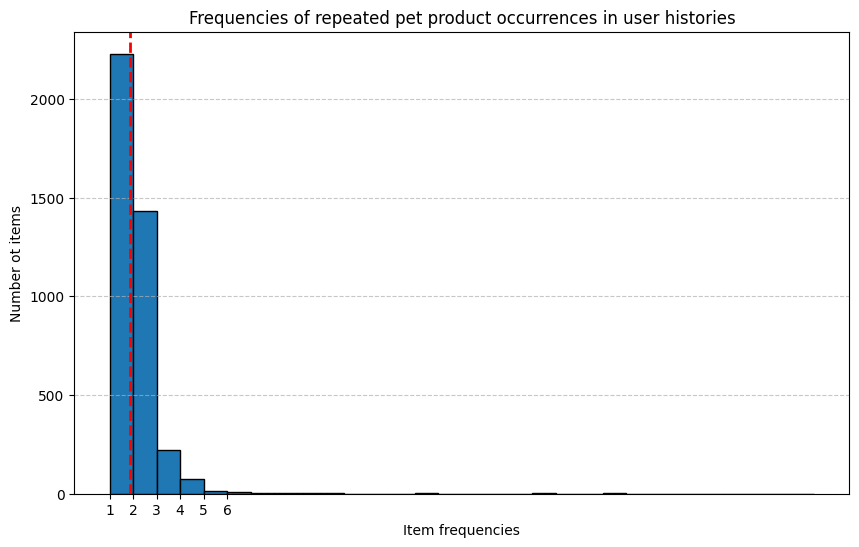

In [ ]:
# Строим гистограмму
plt.figure(figsize=(10, 6))
plt.hist(purchase_frequencies['purchase_count'][:4000], bins=range(1, int(purchase_frequencies['purchase_count'].max()) + 2, 1), edgecolor='black')
plt.title('Frequencies of repeated pet product occurrences in user histories')
plt.xlabel('Item frequencies')
plt.ylabel('Number ot items')
med = np.median(purchase_frequencies['purchase_count'][:4000])
plt.xticks(range(1, 7))
plt.axvline(med, color='red', linestyle='dashed', linewidth=2, label=f'Медиана: {med:.2f}')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
purchase_frequencies['purchase_count'].sum

24609.246440096984

In [ ]:
sum(row)

220114.4330822117

In [ ]:
actions

,user_id,item_id,datetime,weight
0,-1002,5181461,2024-06-14 15:17:25,1
1,-1002,5206702,2024-06-14 15:19:15,1
2,-1002,5119257,2024-06-14 15:21:21,1
3,-1002,5107211,2024-06-28 19:06:10,1
4,-1002,5008694,2024-07-01 18:43:40,1
...,...,...,...,...
449977,1000018836267,5024558,2024-12-01 22:05:45,1
449978,1000018836267,5043136,2024-12-01 22:09:06,1
449979,1000018836267,5047736,2024-12-01 22:11:21,1
449980,1000018839071,5206380,2024-10-14 12:41:04,1


In [ ]:
data = {
    "#users": [19688],
    "#items": [32001],
    "avg. actions / user": [22.9],
    "avg. actions / item": [14],
    "#actions": [450000]
}

df = pd.DataFrame(data)

In [ ]:
df

,#users,#items,avg. actions / user,avg. actions / item,#actions
0,19688,32001,22.9,14,450000


In [ ]:
results.index = results['model']
results = results.iloc[:, [1, 2, 4, 5, 6, 7]]
results

,NDCG@5,Recall@5,CatalogCoverage@5,Novelty@5,Diversity@5,Serendipity@5
model,,,,,,
Popular,0.002270,0.010311,0.000156,8.998690,768.000000,0.000000e+00
PopCat,0.001657,0.006857,0.000156,9.733175,768.000000,9.763978e-07
PopUser,0.030589,0.147857,0.314584,11.390891,763.356488,2.217503e-04
BPR,0.014403,0.065776,0.060967,11.870310,764.570144,5.982352e-05
ALS,0.029411,0.129521,0.047061,11.074199,762.573125,1.103792e-04
SASRec,0.053726,0.224147,0.257898,12.171847,745.712082,3.529361e-04


In [ ]:
r1 = results.iloc[-1].tolist()
r2 = results.iloc[-4].tolist()
r = [f'{round((r1[i]-r2[i])/r1[i], 3)*100}%' for i in range(len(r1))]
# pd.concat([results, r], ignore_index=True)
r

['43.1%', '34.0%', '-22.0%', '6.4%', '-2.4%', '37.2%']

In [ ]:
import pandas as pd

# Исходные данные
data = {
    "NDCG@5": [0.002270, 0.001657, 0.030589, 0.014403, 0.029411, 0.053726],
    "Recall@5": [0.010311, 0.006857, 0.147857, 0.065776, 0.129521, 0.224147],
    "CatalogCoverage@5": [0.000156, 0.000156, 0.314584, 0.060967, 0.047061, 0.257898],
    "Novelty@5": [8.998690, 9.733175, 11.390891, 11.870310, 11.074199, 12.171847],
    "Diversity@5": [768.000000, 768.000000, 763.356488, 764.570144, 762.573125, 745.712082],
    "Serendipity@5": [0.000000e+00, 9.763978e-07, 2.217503e-04, 5.982352e-05, 1.103792e-04, 3.529361e-04]
}

index = ["Popular", "PopCat", "PopUser", "BPR", "ALS", "SASRec"]
df = pd.DataFrame(data, index=index)

# Добавляем строку с разницей
diff_row = pd.DataFrame({
    "NDCG@5": ["+43.1%"],
    "Recall@5": ["+34.0%"],
    "CatalogCoverage@5": ["-22.0%"],
    "Novelty@5": ["+6.4%"],
    "Diversity@5": ["-2.4%"],
    "Serendipity@5": ["+37.2%"]
}, index=["SASRec - PopUser"])

df = pd.concat([df, diff_row])

# Функция для стилизации
def highlight_difference(val):
    if isinstance(val, str) and val.startswith("+"):
        return "color: green; font-weight: bold"
    elif isinstance(val, str) and val.startswith("-"):
        return "color: red; font-weight: bold"
    return ""

# Выделение жирным строк PopUser и SASRec
def bold_models(s):
    return ["font-weight: bold" if s.name in ["PopUser", "SASRec"] else "" for _ in s]

# Применение стилей
styled_df = df.style.applymap(highlight_difference, subset=pd.IndexSlice["SASRec - PopUser", :]) \
                    .apply(bold_models, axis=1)

styled_df

,NDCG@5,Recall@5,CatalogCoverage@5,Novelty@5,Diversity@5,Serendipity@5
Popular,0.002270,0.010311,0.000156,8.998690,768.000000,0.000000
PopCat,0.001657,0.006857,0.000156,9.733175,768.000000,0.000001
PopUser,0.030589,0.147857,0.314584,11.390891,763.356488,0.000222
BPR,0.014403,0.065776,0.060967,11.870310,764.570144,0.000060
ALS,0.029411,0.129521,0.047061,11.074199,762.573125,0.000110
SASRec,0.053726,0.224147,0.257898,12.171847,745.712082,0.000353
SASRec - PopUser,+43.1%,+34.0%,-22.0%,+6.4%,-2.4%,+37.2%
